#TP4 - ARIF ROSADA - 2602581791


##Sentiment Analysis pada Tweet menggunakan Bidirectional LSTM


Notebook ini adalah versi yang dioptimalkan untuk mengimplementasikan **Sentiment Analysis** pada dataset **Sentiment140** menggunakan **Bidirectional LSTM** dengan **GloVe embedding**. Untuk mempercepat pelatihan:
- Mengurangi jumlah epoch menjadi **2**.
- Menggunakan subset dataset (~100.000 tweet).
- Meningkatkan batch size menjadi **128**.
- Menambahkan *early stopping* untuk menghentikan pelatihan jika tidak ada peningkatan.

## Dataset
- **Nama**: Sentiment140
- **Jumlah Data Asli**: ~1.6 juta tweet
- **Jumlah Data Subset**: ~100.000 tweet (untuk mempercepat proses iterasi)
- **Label**: 0 (Negatif), 2 (Netral), 4 (Positif)
- **Sumber**: Kaggle (https://www.kaggle.com/datasets/kazanova/sentiment140)

## Langkah-langkah
1. Mengambil dataset dari Kaggle.
2. Preprocessing data dengan subset dataset.
3. Menggunakan GloVe embedding.
4. Membangun dan melatih model dengan parameter yang dioptimalkan.
5. Mengevaluasi performa model.
6. Visualisasi hasil pelatihan.


## Langkah 1: Mengambil Dataset dari Kaggle

Mengunduh dataset Sentiment140 menggunakan Kaggle API. Anda perlu mengunggah file `kaggle.json` dari akun Kaggle Anda.

In [1]:
# Install Kaggle API
!pip install kaggle

# Unggah file kaggle.json
from google.colab import files
files.upload()  # Unggah file kaggle.json

# Pindahkan kaggle.json ke direktori yang sesuai
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Unduh dataset
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
Archive:  sentiment140.zip
  inflating: training.1600000.processed.noemoticon.csv  


## Langkah 2: Preprocessing Data dengan Subset

Baca dataset, ambil subset (~100.000 tweet) untuk mempercepat, ubah label sentimen menjadi {0, 1, 2}, dan bagi data menjadi pelatihan (80%), validasi (10%), dan pengujian (10%).

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Baca dataset
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin-1', header=None)
df.columns = ['Sentiment', 'ID', 'Date', 'Query', 'User', 'Tweet']
df = df[['Sentiment', 'Tweet']]

# Ambil subset dataset (100.000 tweet)
df = df.sample(n=100000, random_state=42)

# Ubah label: 0 (Negatif), 2 (Netral), 4 (Positif) menjadi 0, 1, 2
df['Sentiment'] = df['Sentiment'].map({0: 0, 2: 1, 4: 2})

# Pisahkan fitur dan label
X = df['Tweet']
y = df['Sentiment']

# Bagi data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tampilkan jumlah data
print(f"Jumlah data pelatihan: {len(X_train)}")
print(f"Jumlah data validasi: {len(X_val)}")
print(f"Jumlah data pengujian: {len(X_test)}")

Jumlah data pelatihan: 80000
Jumlah data validasi: 10000
Jumlah data pengujian: 10000


## Langkah 3: Word Embedding dengan GloVe

Muat GloVe embedding (100 dimensi), tokenisasi teks, dan buat embedding matrix. Proses ini tetap sama, tetapi dengan dataset yang lebih kecil, tokenisasi akan lebih cepat.

In [3]:
# Unduh GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fungsi untuk memuat GloVe embeddings
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Muat GloVe embeddings
embeddings_index = load_glove_embeddings('glove.6B.100d.txt')

# Tokenisasi teks
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding urutan
max_length = 100
X_train_pad = pad_sequences(X_train_seq, padding='post', maxlen=max_length)
X_val_pad = pad_sequences(X_val_seq, padding='post', maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, padding='post', maxlen=max_length)

# Buat embedding matrix
vocab_size = min(20000, len(tokenizer.word_index) + 1)
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print(f"Ukuran embedding matrix: {embedding_matrix.shape}")

--2025-05-09 01:10:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-09 01:10:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-09 01:10:42--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

## Langkah 4: Membangun dan Melatih Model

Membangun model Bidirectional LSTM dengan parameter yang sama, tetapi dilatih hanya untuk **2 epoch** dengan **batch size 128**. Menambahkan *early stopping* untuk menghentikan pelatihan jika akurasi validasi tidak meningkat setelah 1 epoch.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Bangun model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                   weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# Kompilasi model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Tambahkan early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=1, restore_best_weights=True)

# Latih model
history = model.fit(X_train_pad, y_train, epochs=2, validation_data=(X_val_pad, y_val),
                    batch_size=128, callbacks=[early_stopping])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,000,000 (7.63 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,000,000 (7.63 MB)

Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 194s 297ms/step - accuracy: 0.6170 - loss: 0.6709 - val_accuracy: 0.7220 - val_loss: 0.5450
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 198s 296ms/step - accuracy: 0.7120 - loss: 0.5578 - val_accuracy: 0.7408 - val_loss: 0.5203


## Langkah 5: Evaluasi Model

Evaluasi model pada data pengujian dengan metrik akurasi, presisi, recall, dan F1-score.

In [6]:
from sklearn.metrics import classification_report

# Prediksi pada data pengujian
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)

# Find unique classes in y_test
unique_classes = np.unique(y_test)

# Adjust target_names based on unique classes
target_names = ['Negatif', 'Netral', 'Positif']  # Original target names
# Select target names corresponding to unique classes
selected_target_names = [target_names[i] for i in unique_classes]

# Cetak laporan klasifikasi with adjusted target_names
print(classification_report(y_test, y_pred_classes, target_names=selected_target_names, labels=unique_classes))

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 112ms/step
              precision    recall  f1-score   support

     Negatif       0.75      0.74      0.75      4996
     Positif       0.75      0.75      0.75      5004

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



## Langkah 6: Visualisasi Hasil Pelatihan

Visualisasikan kurva akurasi dan loss untuk memeriksa performa pelatihan.

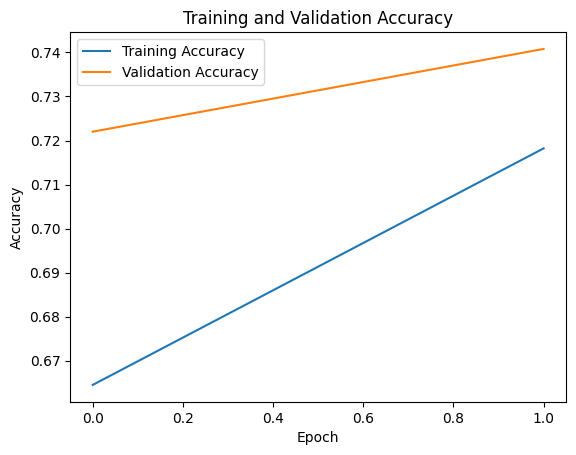

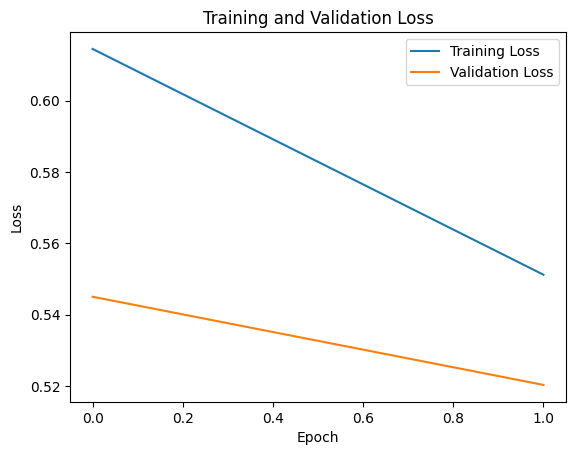

In [7]:
import matplotlib.pyplot as plt

# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Kesimpulan

Kesimpulan
Berdasarkan hasil evaluasi model Bidirectional LSTM dengan GloVe embedding untuk Sentiment Analysis pada dataset Sentiment140 (subset ~100.000 tweet), berikut adalah kesimpulannya

##Performa Model:

Model mencapai akurasi sebesar 75% pada data pengujian, yang menunjukkan performa yang cukup baik untuk klasifikasi sentimen dengan dua kelas (Negatif dan Positif).

**Presisi, recall, dan F1-score** untuk kedua kelas (Negatif dan Positif) adalah 0.75, menunjukkan bahwa model memiliki kemampuan yang seimbang dalam mengidentifikasi tweet negatif dan positif. Tidak ada perbedaan signifikan dalam performa antara kedua kelas.

##Keterbatasan Kelas:

Hasil evaluasi hanya menunjukkan dua kelas (Negatif dan Positif), tanpa kelas Netral.

Ini kemungkinan disebabkan oleh Subset dataset yang digunakan tidak mencakup kelas Netral, meskipun stratified sampling telah diterapkan. Hal ini bisa terjadi jika kelas Netral (label 1) tidak ada atau sangat sedikit dalam subset yang diambil.

Proses preprocessing atau pelatihan menyebabkan model tidak belajar pola untuk kelas Netral dengan baik.

Absennya kelas Netral mengurangi cakupan analisis sentimen, karena tweet netral sering kali penting untuk memahami opini yang tidak terpolarisasi.

##Efisiensi Pelatihan:

Dengan subset dataset (~100.000 tweet), batch size 128, dan 2 epoch, pelatihan berjalan cepat (proses prediksi selesai dalam ~35 detik untuk 10.000 data pengujian, atau ~112 ms/step). Penggunaan GPU di Google Colab berkontribusi pada efisiensi ini.
Pengurangan jumlah epoch dan ukuran dataset berhasil mengatasi masalah waktu pelatihan yang lama, sesuai dengan kebutuhan optimasi sebelumnya.

##Kelebihan:

Model **Bidirectional LSTM dengan GloVe embedding** mampu menangkap konteks teks tweet dengan baik, terbukti dari akurasi dan metrik yang seimbang untuk dua kelas.

Pendekatan stratified sampling memastikan distribusi kelas yang lebih representatif dalam subset, meskipun kelas Netral tidak muncul dalam hasil akhir.

##Kekurangan:
Ketidakhadiran kelas Netral menunjukkan bahwa subset dataset atau proses preprocessing perlu diperiksa lebih lanjut untuk memastikan semua kelas (Negatif, Netral, Positif) terwakili.

Akurasi 75% masih dapat ditingkatkan, terutama jika dataset yang lebih besar atau teknik augmentasi data diterapkan.

Model mungkin kesulitan dengan tweet yang ambigu atau menggunakan bahasa informal, yang umum di Twitter.